In [1]:
"""
Starter code for the problem "Widget sales".

Autonomous Systems Lab (ASL), Stanford University
"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Seed RNG for reproducibility
seed = 0
rng = np.random.default_rng(seed)

# Define the state space, action space, and demand distribution
S = np.array([0, 1, 2, 3, 4, 5])
A = np.array([0, 2, 4])
D = np.array([0, 1, 2, 3, 4])
P = np.array([0.1, 0.3, 0.3, 0.2, 0.1])

In [42]:
def transition(s: int, a: int, d: int) -> int:
    """Compute the next state given the current state, action, and demand."""
    s_next = np.clip(s + a - d, 0, 5)
    return s_next


def reward(s: int, a: int, d: int) -> float:
    """Compute the reward given the current state, action, and demand."""
    price = 1.2
    cost_rent = 1.0
    cost_storage = 0.05 * s
    cost_order = np.sqrt(a)
    r = price * np.minimum(s + a, d) - cost_rent - cost_storage - cost_order
    return r


def simulate(
    rng: np.random.Generator,
    policy: callable,
    T: int,
    s0: int = 5,
    D: np.ndarray = D,
    P: np.ndarray = P,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate widget sales for a given policy."""
    s = np.zeros(T + 1)  # states
    a = np.zeros(T)  # actions
    r = np.zeros(T)  # rewards
    s[0] = s0  # initial state

    for t in tqdm(range(T)):
        # Sample demand
        d = rng.choice(D, p=P)

        # Record action, reward, and next state
        # print(s[t])
        a[t] = policy(s[t])
        r[t] = reward(s[t], a[t], d)
        s[t + 1] = transition(s[t], a[t], d)

    return s, a, r


# Generate historical data with a uniformly random policy
log = {}
T = 3 * 365
log["s"], log["a"], log["r"] = simulate(rng, lambda s, A=A: rng.choice(A), T)


  0%|          | 0/1095 [00:00<?, ?it/s]

In [4]:
rng.choice(A)

2

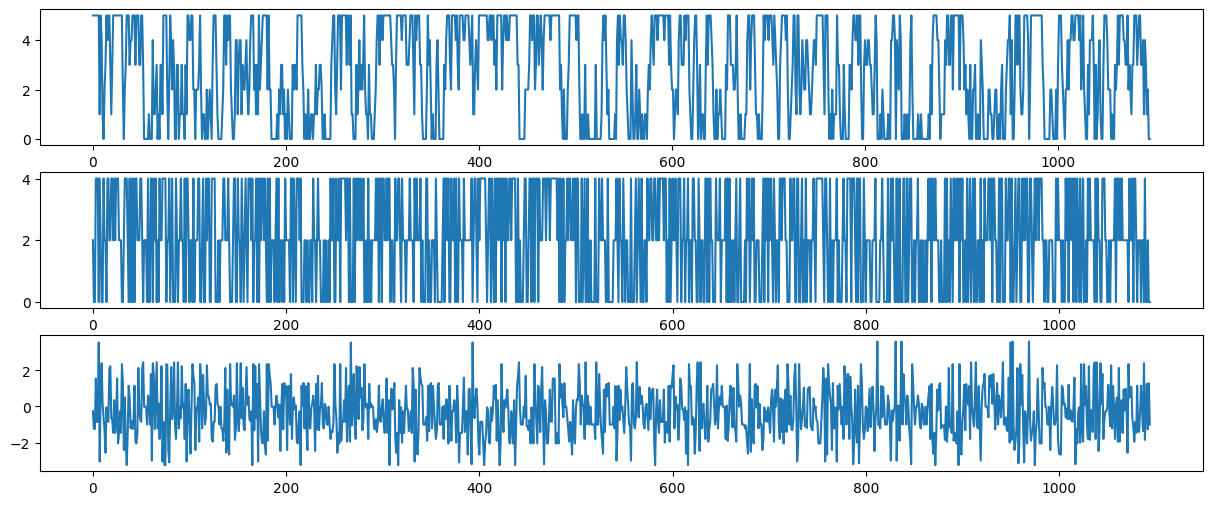

In [5]:
fig, ax = plt.subplots(3,1,figsize=(15,6))
ax[0].plot(log["s"])
ax[1].plot(log["a"])
ax[2].plot(log["r"])

In [6]:
rng.permutation(T)

array([ 123, 1053,  837, ...,  874,  754,  781])

In [8]:
# Do Q-learning
γ = 0.95  # discount factor
α = 1e-2  # learning rate
num_epochs = 5 * int(1 / α)  # number of epochs

Q = np.zeros((S.size, A.size))
Q_epoch = np.zeros((num_epochs + 1, S.size, A.size))

for k in tqdm(range(1, num_epochs + 1)):
    # Shuffle transition tuple indices
    shuffled_indices = rng.permutation(T)

    # ####################### PART (a): YOUR CODE BELOW #######################
    s = int(log['s'][shuffled_indices[0]])
    Q = Q_epoch[k-1]
    # INSTRUCTIONS: Update `Q` using Q-learning.
    for t in shuffled_indices[0:]:

        action = int(log['a'][t])#2 * np.argmax(Q[int(s), :])

        # demand = log['r'][t] + log['a'][t]

        s_next = int(log['s'][t+1])

        r = log['r'][t]

        Q[s, action//2] = Q[s, action//2] + α * (r + γ*np.max(Q[s_next, :]) - Q[s, action//2])

        s = s_next

    # ############################# END PART (a) ##############################

    # Record Q-values for this epoch
    Q_epoch[k] = Q

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
Q

array([[7.96420872, 7.0301462 , 6.655799  ],
       [7.82966127, 7.27831654, 6.67901449],
       [7.9570078 , 7.19002715, 6.63211735],
       [7.91777066, 7.26837102, 6.74948556],
       [7.82082657, 7.24458565, 6.69757475],
       [7.94341434, 7.15014971, 6.6050075 ]])

In [10]:
range(1, num_epochs + 1)

range(1, 501)

In [11]:
Q.shape

(6, 3)

In [12]:
type(A[1]//2)

numpy.int64

In [53]:
# Do value iteration
converged = False
eps = 1e-4
max_iters = 500
Q_vi = np.zeros((S.size, A.size))
Q_vi_prev = np.full(Q_vi.shape, np.inf)

for k in tqdm(range(max_iters)):

    # ####################### PART (b): YOUR CODE BELOW #######################

    # INSTRUCTIONS: Update `Q_vi` using value iteration.
    np.copyto(Q_vi_prev, Q_vi)
    for s in S:
        
        for a in A:
            # print(s, a, a//2)

            # list_V = []

            sum_V = 0
            for d, prob in zip(D, P): 
                s_next = transition(s, a, d)
    
                r_next = reward(s, a, d)
                
    
                R_plus_V = r_next + γ * Q_vi_prev[int(s_next), a//2]
                

                sum_V += prob * R_plus_V
                # print(sum_V)
            # list_V.append(sum_V)


            Q_vi[int(s), a//2] = sum_V
    # break
    
    # ############################# END PART (b) ##############################

    if np.max(np.abs(Q_vi - Q_vi_prev)) < eps:
        converged = True
        print("Value iteration converged after {} iterations.".format(k))
        break
    else:
        # print('False')
        np.copyto(Q_vi_prev, Q_vi)
        # print(Q_vi_prev)
        # break

if not converged:
    raise RuntimeError("Value iteration did not converge!")

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_644312/4106260114.py:31: RuntimeWarning: overflow encountered in scalar add
  sum_V += R_plus_V
/tmp/ipykernel_644312/4106260114.py:41: RuntimeWarning: invalid value encountered in subtract
  if np.max(np.abs(Q_vi - Q_vi_prev)) < eps:


RuntimeError: Value iteration did not converge!

In [49]:
reward_dict = {} 
for d in D:
    reward_d = np.zeros((len(S), len(A)))
    for i, s in enumerate(S):
        for j, a in enumerate(A):
            reward_d[i,j] = reward(s, a, d)
    reward_dict[d] = reward_d
    print('demand', d,'\n', reward_dict[d])

demand 0 
 [[-1.         -2.41421356 -3.        ]
 [-1.05       -2.46421356 -3.05      ]
 [-1.1        -2.51421356 -3.1       ]
 [-1.15       -2.56421356 -3.15      ]
 [-1.2        -2.61421356 -3.2       ]
 [-1.25       -2.66421356 -3.25      ]]
demand 1 
 [[-1.00000000e+00 -1.21421356e+00 -1.80000000e+00]
 [ 1.50000000e-01 -1.26421356e+00 -1.85000000e+00]
 [ 1.00000000e-01 -1.31421356e+00 -1.90000000e+00]
 [ 5.00000000e-02 -1.36421356e+00 -1.95000000e+00]
 [-5.55111512e-17 -1.41421356e+00 -2.00000000e+00]
 [-5.00000000e-02 -1.46421356e+00 -2.05000000e+00]]
demand 2 
 [[-1.         -0.01421356 -0.6       ]
 [ 0.15       -0.06421356 -0.65      ]
 [ 1.3        -0.11421356 -0.7       ]
 [ 1.25       -0.16421356 -0.75      ]
 [ 1.2        -0.21421356 -0.8       ]
 [ 1.15       -0.26421356 -0.85      ]]
demand 3 
 [[-1.         -0.01421356  0.6       ]
 [ 0.15        1.13578644  0.55      ]
 [ 1.3         1.08578644  0.5       ]
 [ 2.45        1.03578644  0.45      ]
 [ 2.4         0.985786

In [52]:
expected_reward = 0.
for d, prob in zip(D, P): 
    expected_reward += prob * reward_dict[d]

expected_reward

array([[-1.        , -0.61421356, -0.72      ],
       [ 0.03      , -0.30421356, -0.77      ],
       [ 0.7       , -0.23421356, -0.82      ],
       [ 1.01      , -0.28421356, -0.87      ],
       [ 1.08      , -0.33421356, -0.92      ],
       [ 1.03      , -0.38421356, -0.97      ]])

In [45]:
reward_dict

{0: array([[-1.        , -2.41421356, -3.        ],
        [-1.05      , -2.46421356, -3.05      ],
        [-1.1       , -2.51421356, -3.1       ],
        [-1.15      , -2.56421356, -3.15      ],
        [-1.2       , -2.61421356, -3.2       ],
        [-1.25      , -2.66421356, -3.25      ]])}

In [27]:
Q_vi_prev

array([[-19.9980444 ,  -7.75735947, -18.94453826],
       [-18.85992286,  -7.22270822, -19.07742775],
       [-17.7611774 ,  -6.97909533, -19.18932498],
       [-16.71420823,  -6.9491377 , -19.27600668],
       [-15.72219523,  -7.01164767, -19.34285445],
       [-14.78518628,  -7.0942084 , -19.39810307]])

In [28]:
np.max(np.abs(Q_vi - Q_vi_prev)) < eps

True

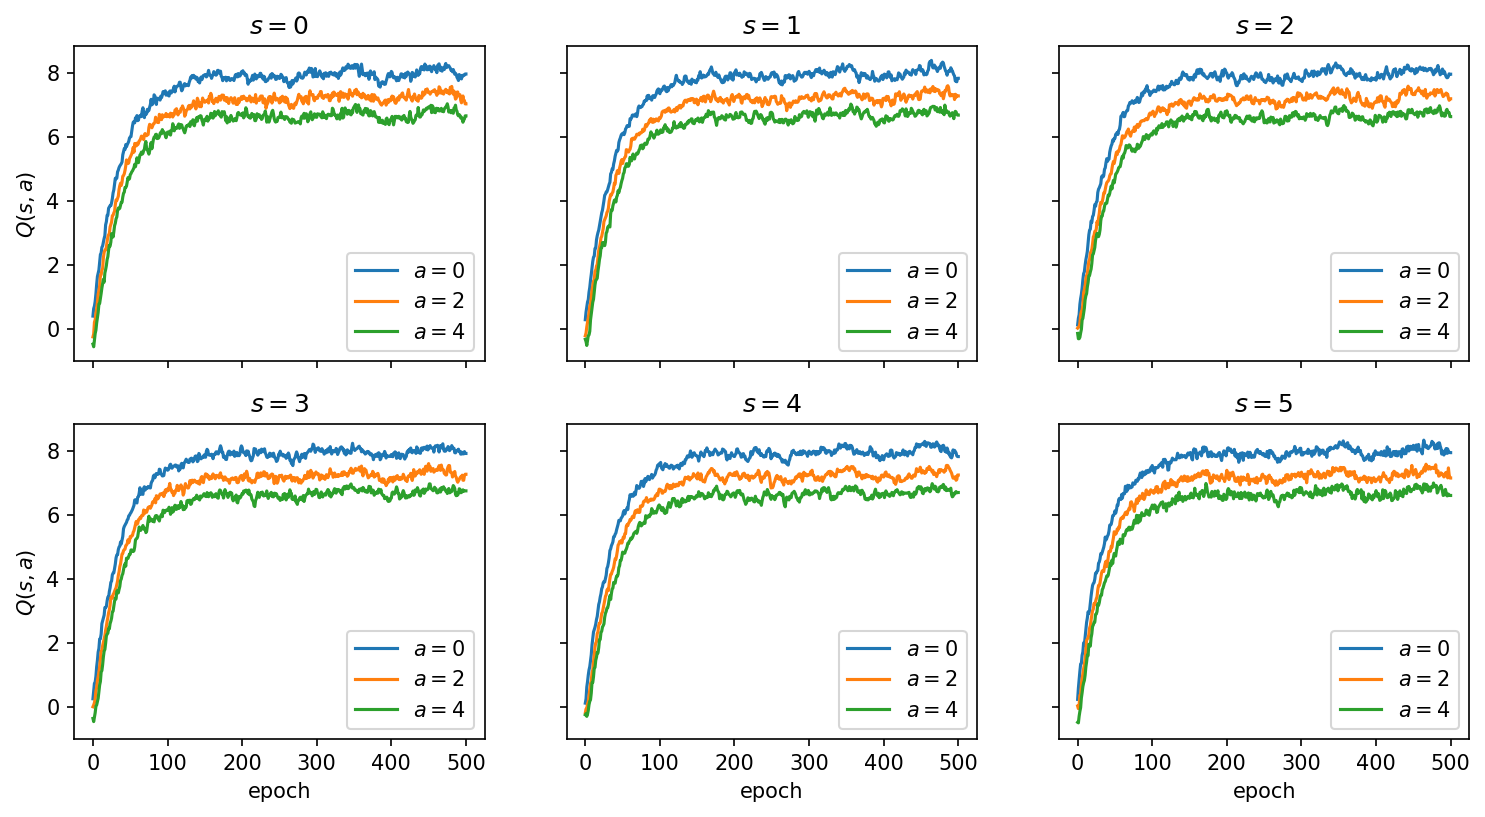

In [54]:
# Plot Q-values for each epoch
fig, axes = plt.subplots(
    2, S.size // 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150
)
fig.subplots_adjust(hspace=0.2)
for i, ax in enumerate(axes.ravel()):
    for j in range(A.size):
        plot = ax.plot(Q_epoch[:, i, j], label="$a = {}$".format(A[j]))
        ax.axhline(Q_vi[i, j], linestyle="--", color=plot[0].get_color())
        ax.legend(loc="lower right")
        ax.set_title(r"$s = {}$".format(S[i]))
for ax in axes[-1, :]:
    ax.set_xlabel("epoch")
for ax in axes[:, 0]:
    ax.set_ylabel("$Q(s,a)$")
fig.savefig("widget_sales_qvalues.png", bbox_inches="tight")
plt.show()

In [30]:
np.argmax(Q_vi, axis=1)*2

array([2, 2, 2, 2, 2, 2])

  0%|          | 0/1825 [00:00<?, ?it/s]

  0%|          | 0/1825 [00:00<?, ?it/s]

Optimal policy (Q-learning):      [3 3 3 3 3 3]
Optimal policy (value iteration): [2 2 2 2 2 2]


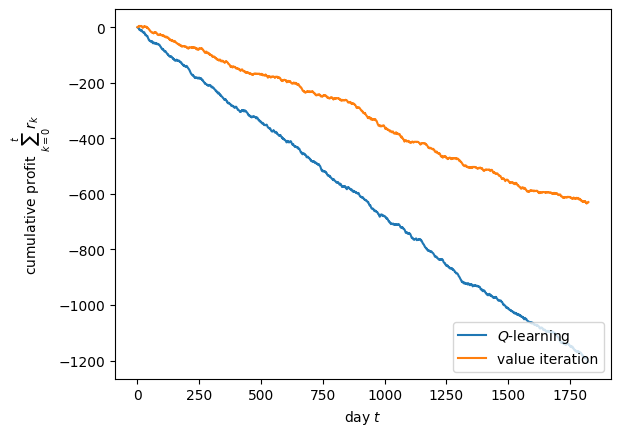

In [35]:
# Report optimal policies from Q-learning and value iteration, simulate them
# for 5 years, and plot the cumulative profits

# ######################### PART (c): YOUR CODE BELOW #########################

# INSTRUCTIONS: Compute the optimal actions `a_opt_ql` and `a_opt_vi` using the
#               Q-values from Q-learning and value iteration, respectively.
#               Both `a_opt_ql` and `a_opt_vi` should be `np.ndarray`s, where
#               each entry is the optimal action for the corresponding state.
#
#               Also, simulate each optimal policy and compute the history of
#               cumulative profits `profit_ql` and `profit_vi` over 5 years
#               (at 365 days per year).

T = 5 * 365

# TODO: replace the next four lines with your code
a_opt_ql = np.argmax(Q, axis=1)+3 #np.zeros(S.size)
r_ql = simulate(rng,
                     lambda s, A=a_opt_ql: A[int(s)],
                     T)[-1] #np.zeros(T)
profit_ql = [sum(r_ql[0:i]) for i in range(len(r_ql))]
a_opt_vi = np.argmax(Q_vi, axis=1)*2 #np.zeros(S.size)
r_vi = simulate(rng,
                     lambda s, A=a_opt_vi: A[int(s)],
                     T)[-1] #np.zeros(T)
profit_vi = [sum(r_vi[0:i]) for i in range(len(r_vi))]

# ############################### END PART (c) ################################

print("Optimal policy (Q-learning):     ", a_opt_ql)
print("Optimal policy (value iteration):", a_opt_vi)

fig, ax = plt.subplots()
ax.plot(profit_ql, label=r"$Q$-learning")
ax.plot(profit_vi, label=r"value iteration")
ax.legend(loc="lower right")
ax.set_xlabel(r"day $t$")
ax.set_ylabel(r"cumulative profit $\sum_{k=0}^t r_k$")
fig.savefig("widget_sales_profits.png", bbox_inches="tight")
plt.show()

In [32]:
Q

array([[7.96420872, 7.0301462 , 6.655799  ],
       [7.82966127, 7.27831654, 6.67901449],
       [7.9570078 , 7.19002715, 6.63211735],
       [7.91777066, 7.26837102, 6.74948556],
       [7.82082657, 7.24458565, 6.69757475],
       [7.94341434, 7.15014971, 6.6050075 ]])

In [33]:
np.argmax(Q, axis=1)

array([0, 0, 0, 0, 0, 0])

In [36]:
Q_vi

array([[-19.99814218,  -7.75739436, -18.9446331 ],
       [-18.86002064,  -7.2227431 , -19.0775226 ],
       [-17.76127518,  -6.97913021, -19.18941983],
       [-16.71430601,  -6.94917258, -19.27610152],
       [-15.72229301,  -7.01168256, -19.3429493 ],
       [-14.78528406,  -7.09424329, -19.39819792]])

In [86]:
profit_vi

(array([5., 4., 5., ..., 5., 4., 3.]),
 array([2., 2., 2., ..., 2., 2., 2.]),
 array([ 0.93578644, -1.41421356,  0.93578644, ..., -1.41421356,
         0.93578644,  0.98578644]))

In [79]:
a_opt_vi

array([0., 0., 0., 0., 0., 0.])